# Data Challenge: Happy Hotel

### Step 1: importing and cleaning data

In [2]:
# import packages to be used

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [117]:
## loading data

os.getcwd()
os.chdir('C:/Users/Huajun/Desktop/Data challenge/')
file = 'hotel_happy_reviews.csv'
data = pd.read_csv(file)
data.info()

file2 = 'hotel_not_happy_reviews.csv'
data2 = pd.read_csv(file2)
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26521 entries, 0 to 26520
Data columns (total 4 columns):
User_ID        26521 non-null object
Description    26521 non-null object
Is_Response    26521 non-null object
hotel_ID       26521 non-null int64
dtypes: int64(1), object(3)
memory usage: 828.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12411 entries, 0 to 12410
Data columns (total 4 columns):
User_ID        12411 non-null object
Description    12411 non-null object
Is_Response    12411 non-null object
hotel_ID       12411 non-null int64
dtypes: int64(1), object(3)
memory usage: 388.0+ KB


In [118]:
## Cleaning data
# check for unique values
print(len(data['User_ID'].unique()))
print(len(data['hotel_ID'].unique()))
print(len(data['Description'].unique()))

print(len(data2['User_ID'].unique()))
print(len(data2['hotel_ID'].unique()))
print(len(data2['Description'].unique()))

26521
10
26521
12411
10
12411


In [119]:
print(data['Is_Response'].value_counts())
print(data2['Is_Response'].value_counts())

happy    26521
Name: Is_Response, dtype: int64
not happy    12411
Name: Is_Response, dtype: int64


In [120]:
## appending two data files together

data = data.append(data2)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38932 entries, 0 to 12410
Data columns (total 4 columns):
User_ID        38932 non-null object
Description    38932 non-null object
Is_Response    38932 non-null object
hotel_ID       38932 non-null int64
dtypes: int64(1), object(3)
memory usage: 1.5+ MB


In [121]:
# double check again for unique values

print(len(data['User_ID'].unique()))
print(len(data['hotel_ID'].unique()))
print(len(data['Description'].unique()))

38932
10
38932


In [122]:
print(data['Is_Response'].value_counts())

happy        26521
not happy    12411
Name: Is_Response, dtype: int64


### Step 2: Identify topics within all hotel reviews

In [34]:
# import packages to be used
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import gensim
from gensim import corpora, models
from nltk.corpus import stopwords

In [124]:
data['Description'][:10]

0    Stayed here with husband and sons on the way t...
1    We had - rooms. One was very nice and clearly ...
2    My wife & I stayed in this glorious city a whi...
3    My boyfriend and I stayed at the Fairmont on a...
4    Steps off Times Square, nice rooms, stayed - n...
5    Me, the Wife and - kids stayed here on Valenti...
6    I highly recommend the Hawthorne Terrace as an...
7    I found the hotel clean and nicely located. Go...
8    Stayed at the Elan from --th to --th October a...
9    We stayed here for - nights and were really ha...
Name: Description, dtype: object

In [126]:
# preprocess texts in reviews
data['Description'] = data['Description'].map(lambda x: re.sub('[,\.!?&]', '', x))
data['Description'] = data['Description'].map(lambda x: x.lower())
data['Description'][:10]

0    stayed here with husband and sons on the way t...
1    we had - rooms one was very nice and clearly h...
2    my wife  i stayed in this glorious city a whil...
3    my boyfriend and i stayed at the fairmont on a...
4    steps off times square nice rooms stayed - nig...
5    me the wife and - kids stayed here on valentin...
6    i highly recommend the hawthorne terrace as an...
7    i found the hotel clean and nicely located goo...
8    stayed at the elan from --th to --th october a...
9    we stayed here for - nights and were really ha...
Name: Description, dtype: object

In [27]:
# plotting the top 20 most common words within these reviews (not differentiating happy or not for now)

def plot_20_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]

    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:20]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 

    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='20 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

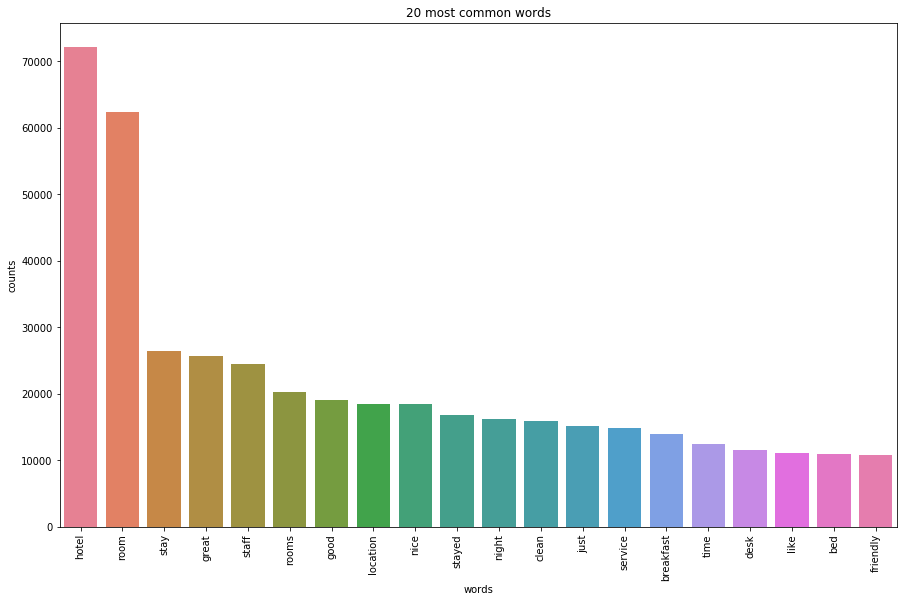

In [28]:
# remove stopwords and plot the top common words
count_vectorizer = CountVectorizer(stop_words='english')
count_data = count_vectorizer.fit_transform(data['Description'])
plot_20_most_common_words(count_data, count_vectorizer)

In [127]:
# top 20 common words not super informative, so decided to tokenize and use LDA models for topic modeling

import nltk
nltk.download('stopwords')
list_stopwords = stopwords.words('English')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Huajun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [132]:
list_stopwords[0:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [134]:
# split each review into words and then remove stopwords

data['tokenized_des'] = data['Description'].apply(lambda x: x.split())
data['tokenized_des'] = data['tokenized_des'].map(lambda tokens: [token.lower() for token in tokens if token.isalpha() \
                                                    and token.lower() not in list_stopwords and len(token)>1])
data['tokenized_des'][0]

0    [stayed, husband, sons, way, alaska, cruise, l...
0    [room, kind, clean, strong, smell, dogs, gener...
Name: tokenized_des, dtype: object

In [135]:
# convert each tokenized review into list of string/words
tokens = data['tokenized_des'].to_list()
tokens[0]

['stayed',
 'husband',
 'sons',
 'way',
 'alaska',
 'cruise',
 'loved',
 'hotel',
 'great',
 'experience',
 'ask',
 'room',
 'north',
 'tower',
 'facing',
 'north',
 'west',
 'best',
 'views',
 'high',
 'floor',
 'stunning',
 'view',
 'needle',
 'city',
 'even',
 'cruise',
 'ships',
 'ordered',
 'room',
 'service',
 'dinner',
 'could',
 'enjoy',
 'perfect',
 'views',
 'room',
 'service',
 'dinners',
 'delicious',
 'perfect',
 'spot',
 'walk',
 'everywhere',
 'enjoy',
 'city',
 'almost',
 'heavenly',
 'beds',
 'heavenly']

In [136]:
# initialize corpora object for LDA models

dictionary_LDA = corpora.Dictionary(tokens)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(token) for token in tokens]

In [137]:
# choose 10 numbers of topics for LDA model

num_topics = 10
%time lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  passes=4, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))

Wall time: 4min 7s


In [138]:
lda_model.print_topics()

[(0,
  '0.026*"service" + 0.011*"one" + 0.009*"get" + 0.008*"bar" + 0.008*"food" + 0.007*"desk" + 0.007*"front" + 0.007*"like" + 0.007*"restaurant" + 0.007*"staff"'),
 (1,
  '0.012*"rooms" + 0.011*"like" + 0.011*"bathroom" + 0.011*"bed" + 0.010*"one" + 0.009*"would" + 0.008*"nice" + 0.008*"stay" + 0.008*"place" + 0.007*"good"'),
 (2,
  '0.045*"breakfast" + 0.022*"coffee" + 0.016*"free" + 0.012*"area" + 0.011*"nice" + 0.010*"good" + 0.010*"clean" + 0.009*"also" + 0.007*"two" + 0.007*"hot"'),
 (3,
  '0.023*"staff" + 0.021*"stay" + 0.013*"stayed" + 0.012*"great" + 0.010*"new" + 0.010*"time" + 0.009*"would" + 0.009*"us" + 0.009*"service" + 0.009*"location"'),
 (4,
  '0.021*"us" + 0.016*"would" + 0.015*"desk" + 0.015*"told" + 0.013*"front" + 0.013*"night" + 0.010*"back" + 0.010*"one" + 0.009*"got" + 0.009*"said"'),
 (5,
  '0.041*"airport" + 0.030*"shuttle" + 0.026*"staff" + 0.019*"stay" + 0.017*"inn" + 0.014*"front" + 0.014*"clean" + 0.014*"service" + 0.014*"desk" + 0.012*"us"'),
 (6,
  '0.

In [139]:
lda_model[corpus[0]]

# first corpus description is 70.6% about topic 7 and 12.9% about topic 9

[(0, 0.07178173),
 (1, 0.039751418),
 (5, 0.052220315),
 (7, 0.706375),
 (9, 0.12878472)]

### Step 3: Create topic-review matrix and merge back to original dataframe

In [142]:
%%time
topics = [lda_model[corpus[i]] for i in range(len(data))]
len(topics)

Wall time: 53.3 s


38932

In [143]:
# define function to create df where topics as columns and rows as input document

def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

In [144]:
# create a matrix of topic weighting, with documents/reviews as rows and topics as columns
document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

In [145]:
document_topic.head(10)

,0,1,2,3,4,5,6,7,8,9
0,0.071781,0.039751,0.000000,0.000000,0.0,0.052226,0.000000,0.706418,0.000000,0.128737
1,0.000000,0.443454,0.000000,0.000000,0.0,0.000000,0.253661,0.103622,0.000000,0.198086
2,0.000000,0.077330,0.000000,0.373155,0.0,0.000000,0.000000,0.548516,0.000000,0.000000
3,0.225273,0.000000,0.000000,0.674118,0.0,0.000000,0.000000,0.000000,0.099121,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.991089,0.000000,0.000000
5,0.128236,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.387117,0.000000,0.482652
6,0.000000,0.000000,0.000000,0.000000,0.0,0.076785,0.000000,0.799350,0.122276,0.000000
7,0.000000,0.315085,0.000000,0.000000,0.0,0.223108,0.062163,0.000000,0.397251,0.000000
8,0.000000,0.000000,0.000000,0.785969,0.0,0.153775,0.000000,0.058933,0.000000,0.000000
9,0.013840,0.000000,0.208971,0.000000,0.0,0.145048,0.482460,0.000000,0.000000,0.149353


In [146]:
document_topic.shape

(38932, 10)

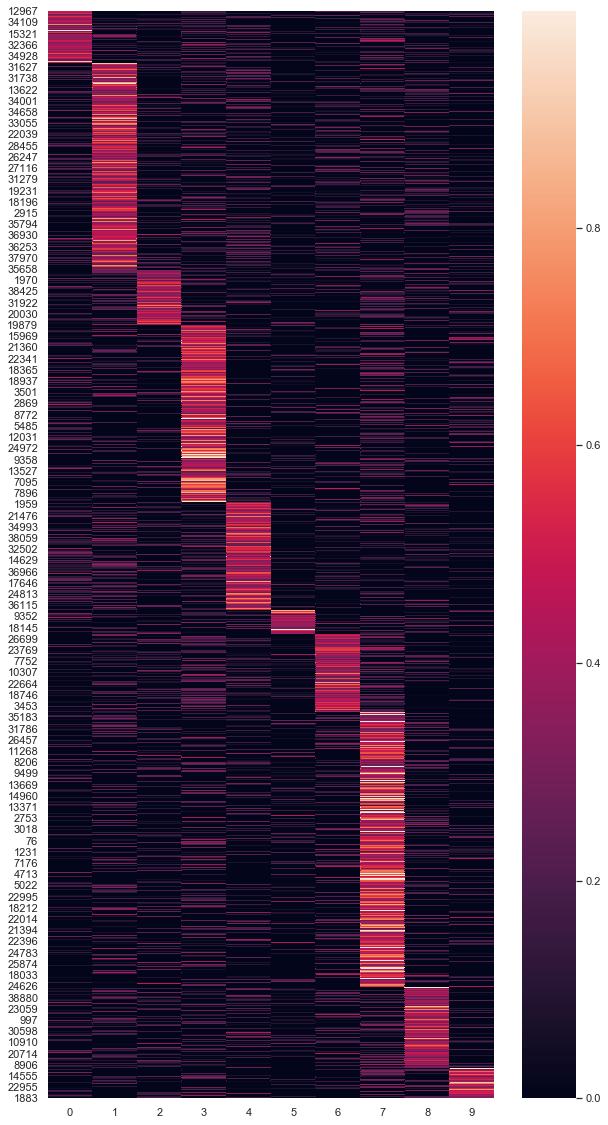

In [148]:
# distribution of topics in all documents

%matplotlib inline
sns.set(rc={'figure.figsize':(10,20)})
sns.heatmap(document_topic.loc[document_topic.idxmax(axis=1).sort_values().index])

In [149]:
# reset indexes for both dataframes for later merging

document_topic['index'] = document_topic.index
data = data.reset_index(drop = True) 
data['index'] = data.index

In [150]:
print(len(document_topic['index'].unique()))
print(len(data['index'].unique()))

38932
38932


In [154]:
merged = data.merge(document_topic, on = 'index')
merged.shape

(38932, 16)

In [152]:
merged.head(10)

,User_ID,Description,Is_Response,hotel_ID,tokenized_des,index,0,1,2,3,4,5,6,7,8,9
0,id10329,stayed here with husband and sons on the way t...,happy,8,"[stayed, husband, sons, way, alaska, cruise, l...",0,0.071781,0.039751,0.000000,0.000000,0.0,0.052226,0.000000,0.706418,0.000000,0.128737
1,id10331,we had - rooms one was very nice and clearly h...,happy,3,"[rooms, one, nice, clearly, updated, recently,...",1,0.000000,0.443454,0.000000,0.000000,0.0,0.000000,0.253661,0.103622,0.000000,0.198086
2,id10333,my wife i stayed in this glorious city a whil...,happy,3,"[wife, stayed, glorious, city, back, sf, expen...",2,0.000000,0.077330,0.000000,0.373155,0.0,0.000000,0.000000,0.548516,0.000000,0.000000
3,id10334,my boyfriend and i stayed at the fairmont on a...,happy,7,"[boyfriend, stayed, fairmont, recent, trip, sa...",3,0.225273,0.000000,0.000000,0.674118,0.0,0.000000,0.000000,0.000000,0.099121,0.000000
4,id10336,steps off times square nice rooms stayed - nig...,happy,3,"[steps, times, square, nice, rooms, stayed, ni...",4,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.991089,0.000000,0.000000
5,id10337,me the wife and - kids stayed here on valentin...,happy,7,"[wife, kids, stayed, weekend, really, nice, ho...",5,0.128236,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.387117,0.000000,0.482652
6,id10339,i highly recommend the hawthorne terrace as an...,happy,8,"[highly, recommend, hawthorne, terrace, afford...",6,0.000000,0.000000,0.000000,0.000000,0.0,0.076785,0.000000,0.799350,0.122276,0.000000
7,id10340,i found the hotel clean and nicely located goo...,happy,3,"[found, hotel, clean, nicely, located, good, f...",7,0.000000,0.315085,0.000000,0.000000,0.0,0.223108,0.062163,0.000000,0.397251,0.000000
8,id10341,stayed at the elan from --th to --th october a...,happy,1,"[stayed, elan, october, liked, much, returned,...",8,0.000000,0.000000,0.000000,0.785969,0.0,0.153775,0.000000,0.058933,0.000000,0.000000
9,id10344,we stayed here for - nights and were really ha...,happy,5,"[stayed, nights, really, happy, located, walk,...",9,0.013840,0.000000,0.208971,0.000000,0.0,0.145048,0.482460,0.000000,0.000000,0.149353


In [153]:
# group by hotel id and get the mean of % relevance per topic by hotels

merged.groupby('hotel_ID').mean()

,index,0,1,2,3,4,5,6,7,8,9
hotel_ID,,,,,,,,,,,
1,21970.108934,0.077309,0.176150,0.059466,0.142059,0.110123,0.037853,0.075909,0.185543,0.085780,0.048041
2,22956.011662,0.078553,0.183207,0.061289,0.129653,0.120626,0.038677,0.080674,0.172749,0.087966,0.044844
3,19429.015545,0.071638,0.151205,0.065558,0.148026,0.098678,0.042022,0.076821,0.208763,0.084409,0.051057
4,19457.661896,0.068353,0.152875,0.066354,0.150093,0.100722,0.039116,0.078877,0.208291,0.084613,0.048933
5,16602.372793,0.065106,0.122917,0.068919,0.163841,0.080990,0.040678,0.081520,0.234530,0.080940,0.058714
6,18771.293863,0.071822,0.148519,0.071189,0.152416,0.090743,0.038418,0.084035,0.205333,0.084549,0.051178
7,21648.918751,0.073684,0.174320,0.062331,0.136818,0.108878,0.036024,0.079930,0.190950,0.086229,0.049087
8,16399.803288,0.061252,0.121459,0.066820,0.165556,0.083616,0.045274,0.080833,0.240491,0.077917,0.054955
9,22659.025100,0.075925,0.177615,0.057539,0.135367,0.123529,0.036082,0.078409,0.175121,0.088285,0.050385


### Step 4: identify topics among reviews specific to each hotel

In [177]:
# generate 1 topic and print words per hotel

%time
num_topics = 1

for i in range(1, 11):
    temp_data = data[data['hotel_ID'] == i]
    temp_tokens = temp_data['tokens']
    print(len(temp_tokens))
    dictionary_LDA = corpora.Dictionary(temp_tokens)
    dictionary_LDA.filter_extremes(no_below=3)
    corpus = [dictionary_LDA.doc2bow(token) for token in temp_tokens]
    lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  passes=4, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))
    print('Topic for Hotel', i)
    print(lda_model.print_topics())

Wall time: 0 ns
3929
Topic for Hotel 1
[(0, '0.010*"stay" + 0.009*"would" + 0.008*"staff" + 0.008*"rooms" + 0.007*"great" + 0.007*"one" + 0.007*"good" + 0.006*"nice" + 0.006*"night" + 0.006*"us"')]
2058
Topic for Hotel 2
[(0, '0.008*"stay" + 0.008*"staff" + 0.008*"rooms" + 0.008*"one" + 0.008*"would" + 0.007*"night" + 0.007*"clean" + 0.006*"service" + 0.006*"good" + 0.006*"stayed"')]
5082
Topic for Hotel 3
[(0, '0.009*"stay" + 0.009*"would" + 0.008*"staff" + 0.008*"one" + 0.008*"great" + 0.007*"rooms" + 0.006*"good" + 0.006*"location" + 0.006*"nice" + 0.006*"night"')]
6847
Topic for Hotel 4
[(0, '0.009*"stay" + 0.009*"would" + 0.008*"staff" + 0.008*"one" + 0.007*"rooms" + 0.007*"great" + 0.006*"good" + 0.006*"nice" + 0.006*"stayed" + 0.006*"us"')]
6682
Topic for Hotel 5
[(0, '0.010*"stay" + 0.009*"would" + 0.008*"great" + 0.008*"rooms" + 0.007*"one" + 0.007*"good" + 0.007*"location" + 0.006*"us" + 0.006*"stayed" + 0.006*"nice"')]
1157
Topic for Hotel 6
[(0, '0.011*"stay" + 0.010*"great